# 01 DataConstruction

## 1. Data Source

To conduct a rigorous replication and robustness analysis, we construct the leverage factor using two distinct datasets:
1.  **Vintage Data:** The original data available to Adrian, Etula, and Muir (2014) at the time of publication.
2.  **Revised Data:** The latest data available from the Federal Reserve (2025), reflecting subsequent statistical revisions.

### 1.1 Vintage Data
- Obtain Macro Data（FRED）from Internet Archive Wayback Machine, which is a TimeMachine(https://web.archive.org/web/20111001000000*/http://www.federalreserve.gov/releases/Z1/Current/Disk/ltabs.zip)
- Table L.129 of the Federal Reserve Flow of Funds report
- the article only uses data starting in 1968, due to in the early years of the data, broker-dealer equity is extremely low or even negative.
- download the data released in March 2011

In [1]:
import pandas as pd
ori_data = pd.read_csv("datasets/ltab129d.csv", sep=" ", index_col=0)
print(ori_data.index[0], '-', ori_data.index[-1])
ori_data = ori_data.loc[196404:200904]
# 格式是 YYYY0Q (如 195201 代表 1952Q1)，将其转换为 pandas 的 PeriodIndex (季度格式)
# 方法：将数字转字符串，拼接成 "1952Q1" 的标准格式
# 1. 取前4位年份
years = ori_data.index.astype(str).str[:4]
# 2. 取最后1位季度
quarters = ori_data.index.astype(str).str[-1]
# 3. 拼接并转换
new_index_str = years + 'Q' + quarters  # 结果如 "1952Q1"
ori_data.index = pd.PeriodIndex(new_index_str, freq='Q')
ori_data.head(5)

195201 - 201003


,FL664090005.Q,FL663020003.Q,FL664004005.Q,FL663069103.Q,FL663061105.Q,FL663061703.Q,FL663062003.Q,FL663063005.Q,FL663069803.Q,FL663064003.Q,...,FL663168005.Q,FL663170003.Q,FL663167005.Q,FL663167003.Q,FL763067005.Q,FL663178003.Q,FL663190005.Q,FL663192003.Q,FL663194005.Q,FL663193005.Q
DATES,,,,,,,,,,,,,,,,,,,,,
1964Q4,9862,681,2674,0,1374,0,693,607,0,897,...,0,350,11220,1785,9435,60,984,298,0,686
1965Q1,9051,687,2104,0,955,0,750,399,0,688,...,0,360,10345,1747,8598,67,976,300,0,676
1965Q2,10499,698,3132,0,1510,0,835,787,0,1077,...,0,360,11885,2041,9844,64,966,291,0,675
1965Q3,8511,709,1721,0,595,0,754,372,0,661,...,0,370,9973,2284,7689,82,947,281,0,666
1965Q4,10349,711,2449,0,1082,0,453,914,0,1203,...,0,370,11968,2691,9277,93,947,281,0,666


### 1.2 Revised Data
- The broker-dealer data is currently presented in Table
L.130 of Flow of Funds
- download the current data from the FRED database maintained by the Federal Reserve Bank
of St. Louis, at https://fred.stlouisfed.org
- The series ID is BOGZ1FL664090005Q for total assets and BOGZ1FL664190005Q for total liabilities.

In [2]:
current_data_40 = pd.read_csv("datasets/BOGZ1FL664090005Q.csv",index_col=0)
current_data_41 = pd.read_csv("datasets/BOGZ1FL664190005Q.csv",index_col=0)
current_data = pd.DataFrame()
current_data['tot_asset'] = current_data_40['BOGZ1FL664090005Q']
current_data['tot_liabilities'] = current_data_41['BOGZ1FL664190005Q']
current_data['Leverage'] = current_data['tot_asset']/(current_data['tot_asset'] - current_data['tot_liabilities'])
current_data = current_data.loc["1964":] #.loc[196404:200904]-04-01":"2009-04-01", ]
current_data.index = pd.to_datetime(current_data.index)
current_data.index = current_data.index.to_period('Q')
current_data.head(5)

,tot_asset,tot_liabilities,Leverage
observation_date,,,
1964Q1,8280.0,7932.0,23.793103
1964Q2,9303.0,8942.0,25.770083
1964Q3,9157.0,8783.0,24.483957
1964Q4,9862.0,9473.0,25.352185
1965Q1,9051.0,8645.0,22.293103


## 2. Constitute "Leverage Factor"

### 2.1 Broker-Dealer Leverage 
- measure of broker-dealer (BD) leverage
- aggregate quarterly data on the levels of total financial assets and total financial liabilities of security broker-dealers as captured in Table L.129 of the Federal Reserve Flow of Funds
- The amounts of Assets and Liabilities are in billions of dollars, not seasonally adjusted

$$Leverage_t^{BD} = \frac{Tot\_Asset_t^{BD}}{Tot\_Asset_t^{BD} - Tot\_Liabilities_t^{BD}}$$

In [3]:
ori_data['tot_asset'] = ori_data['FL664090005.Q']
ori_data['tot_liabilities'] = ori_data['FL664190005.Q']
ori_data['Leverage'] = ori_data['tot_asset']/(ori_data['tot_asset'] - ori_data['tot_liabilities'])

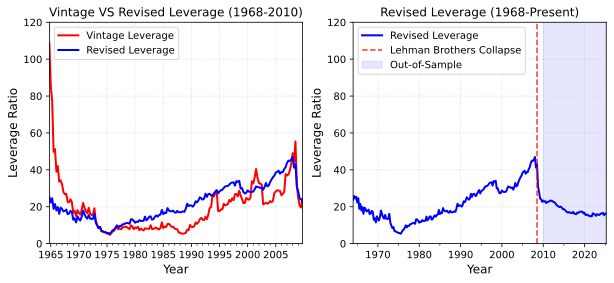

In [4]:
compare_lev = pd.DataFrame()
compare_lev['LevOri'] = ori_data['Leverage']
compare_lev['LevCurrent'] = current_data['Leverage']
compare_lev.index = compare_lev.index.to_timestamp(freq='D') 
current_data_ts = current_data.copy()
current_data_ts.index = current_data.index.to_timestamp(freq='D') 

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# ------------------------------------------------------------------------------------------------------------------------
compare_lev['LevOri'].plot(ax=ax[0], linewidth=2, label='Vintage Leverage', color='r')
compare_lev['LevCurrent'].plot(ax=ax[0], linewidth=2, label='Revised Leverage', color='b')
ax[0].set_title('Vintage VS Revised Leverage (1968-2010)')
ax[0].set_ylabel('Leverage Ratio', fontsize=12)
ax[0].set_xlabel('Year', fontsize=12)
ax[0].set_ylim(0,120)
ax[0].legend(loc='upper left')
ax[0].grid(True, linestyle=':', alpha=0.5)

# ------------------------------------------------------------------------------------------------------------------------
#ax[1].plot(current_data_ts.index, current_data_ts['Leverage'], 'b-', linewidth=2, label='Broker-Dealer Leverage')
current_data_ts['Leverage'].plot(ax=ax[1], linewidth=2, label='Revised Leverage', color='b')

ax[1].axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', alpha=0.8, label='Lehman Brothers Collapse')
ax[1].axvspan(pd.Timestamp('2010-01-01'), current_data_ts.index[-1], color='blue', alpha=0.1, label='Out-of-Sample')

ax[1].set_title('Revised Leverage (1968-Present)')
ax[1].set_ylabel('Leverage Ratio', fontsize=12)
ax[1].set_xlabel('Year', fontsize=12)
ax[1].legend(loc='upper left')
ax[1].grid(True, linestyle=':', alpha=0.5)

ax[1].set_xlim(current_data_ts.index.min(), current_data_ts.index.max())
ax[1].set_ylim(0,120)
#fig.tight_layout()
plt.savefig('figures/Fig1_Broker-Dealer_Leverage.png', dpi=800)
plt.show()

- 使用Original数据得到的Original Leverage（Red line）和使用当前数据计算的Current leverage（Blue line）存在较大差异
- Broker-Dealer Leverage（中介杠杆）从1968年到1975年短暂下降后，直到2008一直在缓慢上升
- 标记的 2008 年危机（标志事件，雷曼兄弟破产），危机后杠杆率大幅下降
- 2010 年以后的数据变平稳（杠杆的波动也下降了）

### 2.2 Leverage Factor
$$LogLev_t^{BD} =  \text{ln}(Leverage_t^{BD})$$
$$\Delta \ln(Leverage_t^{BD}) = \ln(Leverage_t^{BD}) - \ln(Leverage_{t-1}^{BD})$$
$$LevFac_t = \left[\Delta \ln(Leverage_t^{BD})\right]^{SA}$$

- the leverage of broker-dealers computed from the Flow of Funds is a net number, we do not emphasize the level of broker-dealer leverage but instead focus on innovations to broker-dealer leverage.
- 文中提到，由于杠杆率具有高持久性（Persistence），直接使用对数变化量与使用 AR(1) 模型的残差（Innovations）几乎是一样的，为了简化，作者选择了对数变化量 。
- 普通的去季节性通常是对全样本跑一次回归，但这会用到未来的数据（Look-ahead bias）。文章采用了 “扩张窗口回归” (Expanding-window regression) 来模拟“实时”的数据环境。


### 2.3 Real-time Seasonal Adjustment
文章对 LevFac (Broker-Dealer Leverage Factor) 的构建非常具体，为了避免“前视偏差”（Look-ahead Bias），他们采用了一种 “实时扩张窗口去季节性”（Real-time Expanding-window Seasonal Adjustment） 的方法。

具体算法逻辑：对于每一个时间点 $t$（从样本开始到结束）：
- 取数据子集：只使用从起始点到当前时间点 $t$ 的历史数据。
- 构建虚拟变量：设置 4 个季度虚拟变量（Q1, Q2, Q3, Q4）。
- 运行回归：将截止到 $t$ 时刻的 $\Delta \ln(Leverage)$ 对季度虚拟变量进行 OLS 回归。
$$\Delta \ln(Leverage_\tau) = \alpha + \sum_{j=1}^{3} \delta_j D_{j,\tau} + \epsilon_\tau \quad (\text{for } \tau = 1 \dots t)$$(注：通常使用 4 个 dummy 去掉截距，或者 3 个 dummy 加截距，效果一样)
- 获取冲击 (Shock)：当前时刻 $t$ 的残差 $\epsilon_t$ 就是该时刻的 LevFac。 $$LevFac_t = Actual_t - PredictedSeasonalComponent_t$$
- 扩张窗口：移动到 $t+1$ 时刻，重复上述步骤（样本变多了 1 个季度）。

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def seasonal_adj_lev_fac(raw_leverage_series):
    print("--- 1. 检查输入数据 ---")
    print(f"原始数据长度: {len(raw_leverage_series)}")
    print(f"原始索引类型: {type(raw_leverage_series.index)}")
    print(raw_leverage_series.head())

    # 1. 确保是浮点数
    raw_leverage_series = raw_leverage_series.astype(float)

    # 2. 计算 Log Changes
    # 处理 Log 中的负数或零（杠杆率不能为负）

        
    log_lev = np.log(raw_leverage_series)
    d_log_lev = log_lev.diff().dropna()
    
    print(f"\n--- 2. 检查对数差分后数据 (y) ---")
    print(f"y 长度: {len(d_log_lev)}")
    print(d_log_lev.head())

    # 3. 构造季度 Dummies
    # 强制确保索引具备 .quarter 属性
    try:
        quarters = d_log_lev.index.quarter
    except AttributeError:
        print("\n❌ 错误：索引不是时间类型(Datetime/Period)，无法提取季度！")
        print("请先运行：df.index = pd.PeriodIndex(df.index, freq='Q')")
        return pd.Series([np.nan]*len(d_log_lev), index=d_log_lev.index)

    # 关键修复：astype(float)
    dummies = pd.get_dummies(quarters, prefix='Q').astype(float)

    # === 关键修复：强制对齐索引 ===
    # 直接把 dummy 的 index 覆盖为 y 的 index，确保绝对匹配
    dummies.index = d_log_lev.index
    
    # 添加截距
    # X = sm.add_constant(dummies)
    X = dummies
    
    print(f"\n--- 3. 检查自变量矩阵 (X) ---")
    print(X.head())

    # 4. 扩张窗口回归
    lev_shocks = []
    min_periods = 12  # 至少需要 12 个季度
    
    if len(d_log_lev) <= min_periods:
        print(f"\n❌ 错误：样本量 ({len(d_log_lev)}) 小于最小窗口 ({min_periods})")
        return pd.Series(np.nan, index=d_log_lev.index)
    

    print("\n--- 4. 开始循环回归 ---")
    error_count = 0
    
    # 使用 tqdm 显示进度（如果有的话），没有就普通循环
    # 这里的 range 确保了索引是对齐的
    indices = d_log_lev.index
    
    for i in range(min_periods, len(d_log_lev)):
        # 显式使用 iloc 切片，避免索引对齐问题
        curr_y = d_log_lev.iloc[:i+1]
        curr_X = X.iloc[:i+1]
        
        try:
            # 运行回归
            model = sm.OLS(curr_y, curr_X).fit()
            # 取最后一个残差
            lev_shocks.append(model.resid.iloc[-1])
            
        except Exception as e:
            if error_count < 3: # 只打印前3个错误
                print(f"回归在第 {i} 步失败: {e}")
            error_count += 1
            lev_shocks.append(np.nan)

    # 结果对齐
    # 结果的长度是 len(d_log_lev) - min_periods
    result_index = d_log_lev.index[min_periods:]
    lev_fac = pd.Series(lev_shocks, index=result_index)
    
    print(f"\n✅ 完成！生成因子长度: {len(lev_fac)}")
    print(f"非 NaN 数量: {lev_fac.notna().sum()}")
    print(lev_fac.head())
    
    return lev_fac, log_lev


In [6]:
ori_lev_fac, ori_log_lev = seasonal_adj_lev_fac(ori_data['Leverage'])

--- 1. 检查输入数据 ---
原始数据长度: 181
原始索引类型: <class 'pandas.core.indexes.period.PeriodIndex'>
DATES
1964Q4    108.373626
1965Q1     85.386792
1965Q2     77.198529
1965Q3     49.771930
1965Q4     51.232673
Freq: Q-DEC, Name: Leverage, dtype: float64

--- 2. 检查对数差分后数据 (y) ---
y 长度: 180
DATES
1965Q1   -0.238393
1965Q2   -0.100811
1965Q3   -0.438929
1965Q4    0.028926
1966Q1   -0.273145
Freq: Q-DEC, Name: Leverage, dtype: float64

--- 3. 检查自变量矩阵 (X) ---
        Q_1  Q_2  Q_3  Q_4
DATES                     
1965Q1  1.0  0.0  0.0  0.0
1965Q2  0.0  1.0  0.0  0.0
1965Q3  0.0  0.0  1.0  0.0
1965Q4  0.0  0.0  0.0  1.0
1966Q1  1.0  0.0  0.0  0.0

--- 4. 开始循环回归 ---

✅ 完成！生成因子长度: 168
非 NaN 数量: 168
DATES
1968Q1    0.010283
1968Q2    0.037533
1968Q3    0.226723
1968Q4   -0.063279
1969Q1   -0.088941
Freq: Q-DEC, dtype: float64


In [7]:
current_lev_fac, current_log_lev = seasonal_adj_lev_fac(current_data['Leverage'])

--- 1. 检查输入数据 ---
原始数据长度: 246
原始索引类型: <class 'pandas.core.indexes.period.PeriodIndex'>
observation_date
1964Q1    23.793103
1964Q2    25.770083
1964Q3    24.483957
1964Q4    25.352185
1965Q1    22.293103
Freq: Q-DEC, Name: Leverage, dtype: float64

--- 2. 检查对数差分后数据 (y) ---
y 长度: 245
observation_date
1964Q2    0.079818
1964Q3   -0.051196
1964Q4    0.034847
1965Q1   -0.128588
1965Q2    0.097974
Freq: Q-DEC, Name: Leverage, dtype: float64

--- 3. 检查自变量矩阵 (X) ---
                  Q_1  Q_2  Q_3  Q_4
observation_date                    
1964Q2            0.0  1.0  0.0  0.0
1964Q3            0.0  0.0  1.0  0.0
1964Q4            0.0  0.0  0.0  1.0
1965Q1            1.0  0.0  0.0  0.0
1965Q2            0.0  1.0  0.0  0.0

--- 4. 开始循环回归 ---

✅ 完成！生成因子长度: 233
非 NaN 数量: 233
observation_date
1967Q2   -0.126997
1967Q3    0.145527
1967Q4   -0.060822
1968Q1   -0.023053
1968Q2   -0.020950
Freq: Q-DEC, dtype: float64


In [8]:
### No seasonla adjustement
no_season_log_lev = ori_data['Leverage'].apply(np.log)
no_season_lev_fac = ori_data['Leverage'].apply(np.log).diff()

In [9]:
# new_log_lev = current_data['Leverage'].apply(np.log)
# new_lev_fac = current_data['Leverage'].apply(np.log).diff()

### 2.4 Standardization(Z-Score)
We standardize each series to have zero mean and unit variance for convenience.
$$ X = \frac{X-\mu}{\sigma}$$

In [10]:
def Zscore(factor):
    return (factor - factor.mean())/(factor.std())

In [11]:
ori_data['LevFac'] = ori_lev_fac
ori_data['LogLev'] = ori_log_lev
ori_data['Z-LevFac'] = Zscore(ori_lev_fac)
ori_data['Z-LogLev'] = Zscore(ori_log_lev)
ori_data['No Seasonal-Adj LevFac'] = Zscore(no_season_lev_fac)
ori_data['No Seasonal-Adj LogLev'] = Zscore(no_season_log_lev)
ori_data = ori_data.dropna()
ori_data = ori_data.loc["1968Q1":]

In [12]:
current_data['LevFac'] = current_lev_fac
current_data['LogLev'] = current_log_lev
current_data['Z-LevFac'] = Zscore(current_lev_fac)
current_data['Z-LogLev'] = Zscore(current_log_lev)
current_data = current_data.dropna()
current_data = current_data.loc["1968Q1":]
current_data.to_csv('RevisedData.csv')

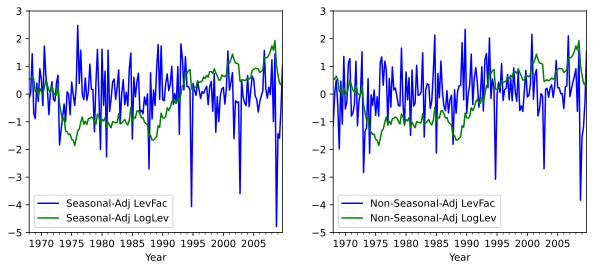

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ori_data[['Z-LevFac', 'Z-LogLev']].plot(ax=ax[0], color=['blue', 'green'])
ax[0].legend(['Seasonal-Adj LevFac', 'Seasonal-Adj LogLev'], loc='lower left')
ax[0].set_xlabel('Year')
ax[0].grid(False)
ax[0].set_ylim(-5, 3)  # 设置纵坐标范围为 -5 到 3
ax[1].set_xlabel('Year')
ori_data[['No Seasonal-Adj LevFac', 'No Seasonal-Adj LogLev']].plot(ax=ax[1], color=['blue', 'green'])
ax[1].legend(['Non-Seasonal-Adj LevFac', 'Non-Seasonal-Adj LogLev'], loc='lower left')
ax[1].set_xlabel('Year')
ax[1].grid(False)
ax[1].set_ylim(-5, 3)  # 设置纵坐标范围为 -5 到 3
ax[1].set_xlabel('Year')
plt.savefig('figures/f2-seasonal_adj_leverage_plot.png', dpi=800)

- 复现了原文Figure 2. Log-leverage and leverage factor. “We plot the log-leverage and the leverage factor
(changes in log-leverage) of security broker-dealers, 1968Q1 to 2009Q4. We standardize each series
to have zero mean and unit variance for convenience.”
- 经过季节性调整的LevFac对比没有经过季节性调整的LevFac，两者在尖峰位置存在明显的差异
- 经过季节性调整的LevFac比没有经过季节性调整的LevFac更接近原文的Figure2，用肉眼对比几乎一致

## 3. Old VS New LevFac
- Comparison of the two leverage factors constructed from the two versions of the Flow of Funds
data. 
- repurchase agreements and foreign direct investments, has been change.

In [14]:
compare_lev_fac = pd.DataFrame()
# ------original
compare_lev_fac['LevFacOri'] = ori_data['LevFac']
compare_lev_fac['ZLevFacOri'] = ori_data['Z-LevFac']
compare_lev_fac['ZLogLevOri'] = ori_data['Z-LogLev']
# -------new
compare_lev_fac['LevFacCurrent'] = current_data['LevFac']
compare_lev_fac['ZLevFacCurrent'] = current_data['Z-LevFac']
compare_lev_fac['ZLogLevCurrent'] = current_data['Z-LogLev']

compare_lev_fac.to_csv('LevFac.csv')
compare_lev_fac

,LevFacOri,ZLevFacOri,ZLogLevOri,LevFacCurrent,ZLevFacCurrent,ZLogLevCurrent
DATES,,,,,,
1968Q1,0.010283,-0.149858,0.548915,-0.023053,-0.357735,-0.403461
1968Q2,0.037533,0.052167,0.539366,-0.020950,-0.330748,-0.350469
1968Q3,0.226723,1.454775,0.641359,0.164599,2.050487,-0.166876
1968Q4,-0.063279,-0.695224,0.542090,-0.102191,-1.373345,-0.235790
1969Q1,-0.088941,-0.885478,0.082964,-0.131515,-1.749673,-0.891270
...,...,...,...,...,...,...
2008Q4,-0.614654,-4.782984,1.048600,-0.370011,-4.810401,1.104707
2009Q1,-0.161919,-1.426519,0.684362,-0.047752,-0.674710,0.894071
2009Q2,-0.184683,-1.595289,0.399756,-0.154505,-2.044721,0.567141


In [15]:
compare_lev_fac[['ZLevFacOri', 'ZLevFacCurrent']].corr()

,ZLevFacOri,ZLevFacCurrent
ZLevFacOri,1.000000,0.694332
ZLevFacCurrent,0.694332,1.000000


- 相关性只有0.8140

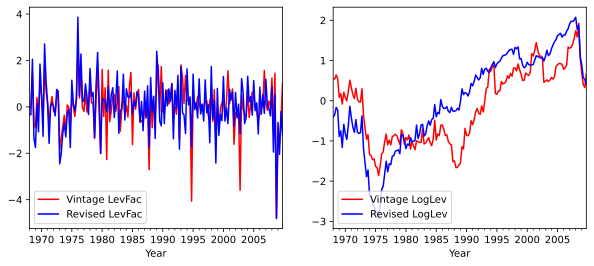

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
compare_lev_fac[['ZLevFacOri', 'ZLevFacCurrent']].plot(ax=ax[0], color=['red', 'blue'])
ax[0].legend(['Vintage LevFac', 'Revised LevFac'], loc='lower left')
ax[0].set_xlabel('Year')
ax[0].grid(False)
compare_lev_fac[['ZLogLevOri', 'ZLogLevCurrent']].plot(ax=ax[1], color=['red', 'blue'])
ax[1].legend(['Vintage LogLev', 'Revised LogLev'], loc='lower left')
ax[1].set_xlabel('Year')
ax[1].grid(False)
plt.savefig('figures/f3-compare_leverage_plot.png', dpi=800)